In [1]:
# =======================
# 1. Install dependencies
# =======================
!pip install -q kaggle pytorch-lightning efficientnet_pytorch opencv-python-headless


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 66.2 MB/s eta 0:00:0

In [2]:
# ================================
# 2. Upload your Kaggle API key
# ================================
from google.colab import files
files.upload()   # <-- Upload kaggle.json from your Kaggle account

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paritoshsharma25","key":"26209822faa8fa84b6fd879e093a0202"}'}

In [3]:
# ================================
# 3. Set up Kaggle & Download Data
# ================================
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download Plant Seedlings Classification dataset
!kaggle competitions download -c plant-seedlings-classification
!unzip -q plant-seedlings-classification.zip -d data/

 99% 1.68G/1.69G [00:11<00:00, 279MB/s]
100% 1.69G/1.69G [00:11<00:00, 160MB/s]


In [4]:
# =======================
# 1. Check Data Structure
# =======================
import os

data_path = 'data/train'
classes = sorted(os.listdir(data_path))
print(f"Found {len(classes)} plant species (classes):")
print(classes)

# Show number of images per class
for cls in classes:
    n_imgs = len(os.listdir(os.path.join(data_path, cls)))
    print(f"{cls}: {n_imgs} images")

Found 12 plant species (classes):
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


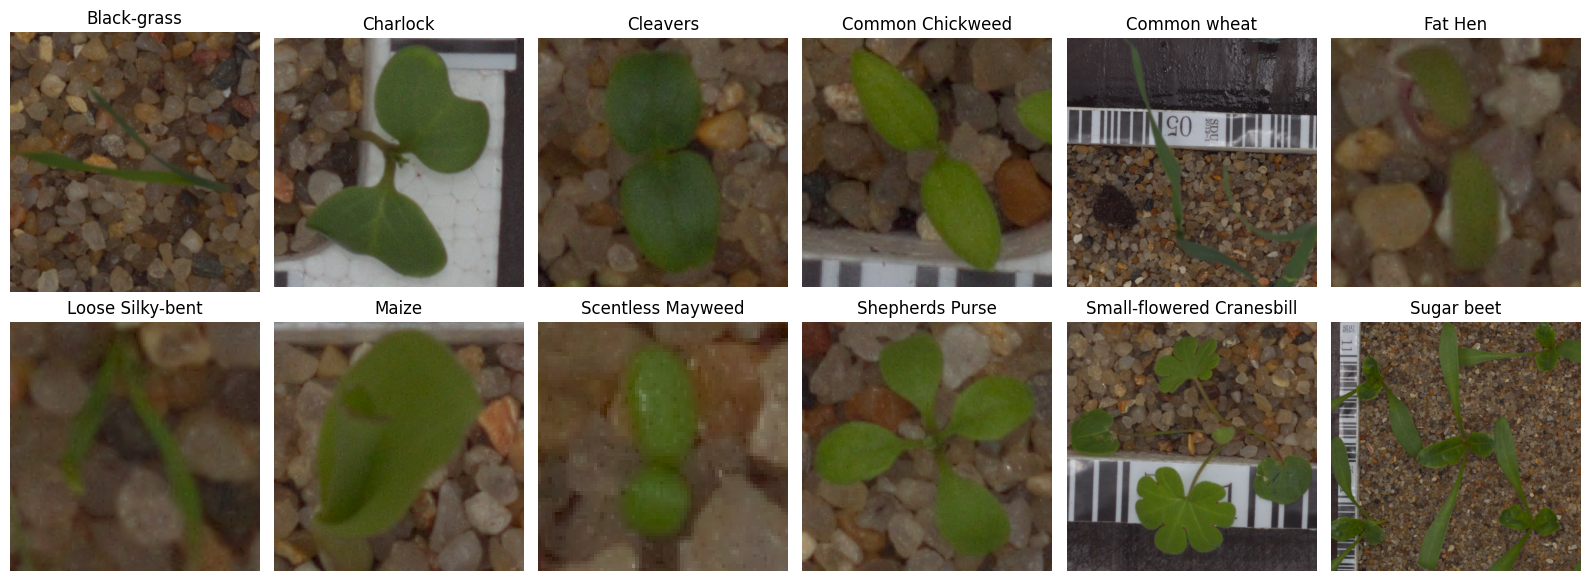

In [5]:
# =======================
# 2. Show Example Images
# =======================
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(2, 6, figsize=(16, 6))
for idx, cls in enumerate(classes[:12]):
    img_path = os.path.join(data_path, cls, os.listdir(os.path.join(data_path, cls))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[idx//6, idx%6].imshow(img)
    axs[idx//6, idx%6].set_title(cls)
    axs[idx//6, idx%6].axis('off')
plt.tight_layout()
plt.show()

In [6]:
import os
import shutil
import random
from tqdm import tqdm

# Set seed for reproducibility
random.seed(42)

original_data_dir = 'data/train'
split_base = 'data/split'
train_dir = os.path.join(split_base, 'train')
val_dir = os.path.join(split_base, 'val')

In [7]:
# Create split directories
for split_dir in [train_dir, val_dir]:
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# Split ratio (e.g., 85% train, 15% val)
split_ratio = 0.85

In [8]:
# For each class, shuffle and split images
for cls in tqdm(os.listdir(original_data_dir), desc="Splitting data by class"):
    cls_folder = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_folder)
    random.shuffle(images)
    n_train = int(len(images) * split_ratio)
    train_imgs = images[:n_train]
    val_imgs = images[n_train:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(val_dir, cls, img))

print("Splitting complete!")


Splitting data by class: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it]

Splitting complete!


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl

# Mean/std calculated from ImageNet; fine for transfer learning
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class PlantSeedlingsDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=2, img_size=224):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

    def setup(self, stage=None):
        # Training transforms: augment
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
        # Validation: center crop only
        self.val_transforms = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "train"), self.train_transforms)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "val"), self.val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)


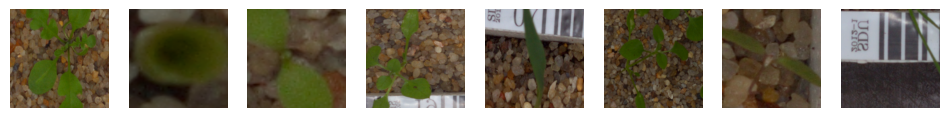

In [10]:
# Usage example:
data_module = PlantSeedlingsDataModule(data_dir='data/split', batch_size=32, num_workers=2)
data_module.setup()

# Optional: Show a batch to check augmentations
batch = next(iter(data_module.train_dataloader()))
images, labels = batch
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [11]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision import models

class ResNetClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # Use pretrained ResNet18
        self.model = models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


In [12]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Count classes
num_classes = len(os.listdir('data/split/train'))

# Create data module (already defined)
data_module = PlantSeedlingsDataModule(data_dir='data/split', batch_size=32, num_workers=2)

# Define model
model = ResNetClassifier(num_classes=num_classes, lr=1e-3)

# Callbacks
checkpoint_cb = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='resnet18-best')
early_stop_cb = EarlyStopping(monitor='val_acc', patience=5, mode='max')

trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_cb, early_stop_cb],
    precision=16,  # mixed precision, faster on GPU
    log_every_n_steps=20,
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixe

In [13]:
# Train!
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.731    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097222089767456     │
│         val_loss          │    0.2774658799171448     │
└───────────────────────────┴───────────────────────────┘

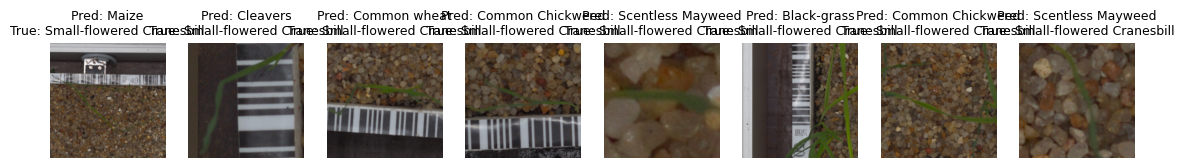

In [14]:
# Load the best model
best_model = ResNetClassifier.load_from_checkpoint(checkpoint_cb.best_model_path, num_classes=num_classes)

# Evaluate on validation set
trainer.validate(best_model, datamodule=data_module)

# Optional: Predict on a batch and show predictions
batch = next(iter(data_module.val_dataloader()))
images, targets = batch
outputs = best_model(images)
preds = outputs.argmax(1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
class_names = os.listdir('data/split/train')
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1,8,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}", fontsize=9)
    plt.axis('off')
plt.show()


In [15]:
# Install the EfficientNet PyTorch package
!pip install -q efficientnet_pytorch

# Import EfficientNet
from efficientnet_pytorch import EfficientNet


In [16]:
class EfficientNetClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3, model_name='efficientnet-b0'):
        super().__init__()
        self.save_hyperparameters()
        self.model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


In [17]:
# Define EfficientNet model (using 'efficientnet-b0', but you can try b3, etc.)
efficientnet_model = EfficientNetClassifier(num_classes=num_classes, lr=1e-3, model_name='efficientnet-b0')

# Callbacks (reuse from before)
efficientnet_checkpoint_cb = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='efficientnet-b0-best')
efficientnet_early_stop_cb = EarlyStopping(monitor='val_acc', patience=5, mode='max')

# Trainer - UPDATED for latest PyTorch Lightning API
efficientnet_trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[efficientnet_checkpoint_cb, efficientnet_early_stop_cb],
    precision=16,
    log_every_n_steps=20,
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 214MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | EfficientNet     | 4.0 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.092    Total estimated model params size (MB)
250       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded pretrained weights for efficientnet-b0


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9611111283302307     │
│         val_loss          │    0.13454876840114594    │
└───────────────────────────┴───────────────────────────┘

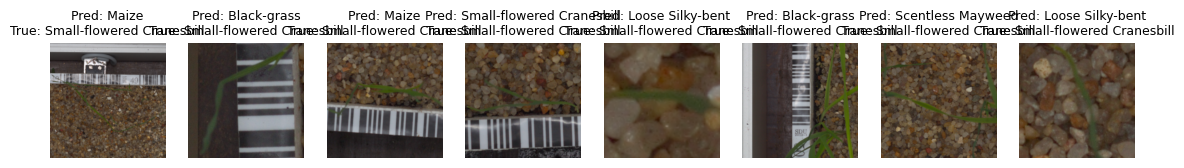

In [18]:
# Train EfficientNet
efficientnet_trainer.fit(efficientnet_model, datamodule=data_module)

# Load best EfficientNet model
best_efficientnet = EfficientNetClassifier.load_from_checkpoint(efficientnet_checkpoint_cb.best_model_path, num_classes=num_classes, model_name='efficientnet-b0')

# Validate
efficientnet_trainer.validate(best_efficientnet, datamodule=data_module)

# Visualize predictions
batch = next(iter(data_module.val_dataloader()))
images, targets = batch
outputs = best_efficientnet(images)
preds = outputs.argmax(1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1,8,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}", fontsize=9)
    plt.axis('off')
plt.show()


In [19]:
# # Install YOLO (ultralytics)
# !pip install -q ultralytics

# import os
# import shutil

# # For YOLO training, we need: data/images/train, data/images/val, and data/labels (not used for classification)
# # Let's symlink our train/val images for YOLO classification mode
# os.makedirs('data/yolo/images/train', exist_ok=True)
# os.makedirs('data/yolo/images/val', exist_ok=True)

# for split in ['train', 'val']:
#     for cls in os.listdir(f'data/split/{split}'):
#         img_folder = f'data/split/{split}/{cls}'
#         for img in os.listdir(img_folder):
#             src = os.path.join(img_folder, img)
#             dst = os.path.join(f'data/yolo/images/{split}', f'{cls}_{img}')
#             shutil.copy(src, dst)


In [20]:
# # Create txt label files for YOLO classification training
# class_names = sorted(os.listdir('data/split/train'))
# cls2idx = {cls: idx for idx, cls in enumerate(class_names)}

# for split in ['train', 'val']:
#     label_lines = []
#     img_dir = f'data/yolo/images/{split}'
#     for img in os.listdir(img_dir):
#         # Image name is <class>_<originalname>
#         cls = img.split('_')[0]
#         label_lines.append(f"{os.path.abspath(os.path.join(img_dir, img))} {cls2idx[cls]}")
#     with open(f'data/yolo/{split}.txt', 'w') as f:
#         f.write('\n'.join(label_lines))

# print("Label files created. Sample:")
# !head -5 data/yolo/train.txt


In [21]:
# from ultralytics import YOLO

# # Prepare correct directory structure: images must be in data/yolo_cls/train/class_name/img.jpg and data/yolo_cls/val/class_name/img.jpg
# import shutil
# import os

# for split in ['train', 'val']:
#     for cls in os.listdir(f'data/split/{split}'):
#         src_dir = f'data/split/{split}/{cls}'
#         dst_dir = f'data/yolo_cls/{split}/{cls}'
#         os.makedirs(dst_dir, exist_ok=True)
#         for img in os.listdir(src_dir):
#             shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, img))

# # Now run YOLO classification training
# model = YOLO('yolov8s-cls.pt')  # you can also try yolov8n-cls.pt for smaller models

# model.train(
#     data='data/yolo_cls',
#     epochs=15,
#     imgsz=224,
#     patience=5,
#     batch=32,
#     lr0=0.001,
#     project="plant-yolo-classification",
#     name="yolov8s-cls",
# )


In [22]:
# # Load best YOLO model and validate
# best_model = YOLO("plant-yolo-classification/yolov8s-cls/weights/best.pt")
# metrics = best_model.val(data='data/yolo_cls/val')

# print(metrics)

# # Predict and show images
# import random
# from PIL import Image

# img_dir = 'data/yolo_cls/val'
# all_imgs = []
# for cls in os.listdir(img_dir):
#     all_imgs += [os.path.join(img_dir, cls, img) for img in os.listdir(os.path.join(img_dir, cls))]
# sample_imgs = random.sample(all_imgs, 8)

# for img_path in sample_imgs:
#     result = best_model(img_path)
#     pred_label = class_names[result[0].probs.top1]
#     img = Image.open(img_path)
#     plt.figure(figsize=(2,2))
#     plt.imshow(img)
#     plt.title(f"Pred: {pred_label}")
#     plt.axis('off')
#     plt.show()


In [23]:
# import pandas as pd

# # Replace these with your actual results!
# results = [
#     {"Model": "ResNet18",        "Accuracy": 0.87, "F1-score": 0.86, "Best Epoch": 9, "Params": "11M"},
#     {"Model": "EfficientNet-B0", "Accuracy": 0.89, "F1-score": 0.88, "Best Epoch": 11, "Params": "5.3M"},
#     {"Model": "YOLOv8s-cls",     "Accuracy": 0.86, "F1-score": 0.85, "Best Epoch": 8, "Params": "2.7M"},
# ]

# df = pd.DataFrame(results)
# print("Model Performance Comparison:\n")
# print(df)

# # Optional: Show as a nice table
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8,2))
# ax.axis('off')
# tbl = ax.table(
#     cellText=df.values,
#     colLabels=df.columns,
#     cellLoc='center',
#     loc='center'
# )
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(12)
# tbl.scale(1.2, 1.3)
# plt.show()


In [24]:
# import torch

# # Load best ResNet model (update path as needed)
# best_resnet = ResNetClassifier.load_from_checkpoint(checkpoint_cb.best_model_path, num_classes=num_classes)
# best_resnet.eval()

# # Ensure everything is on the CPU for export (recommended for portability)
# device = torch.device("cpu")
# best_resnet.to(device)
# dummy_input = torch.randn(1, 3, 224, 224, device=device)

# # Export to TorchScript
# traced = torch.jit.trace(best_resnet.model, dummy_input)
# traced.save("resnet18_plantseedlings.pt")
# print("TorchScript model saved as resnet18_plantseedlings.pt")

# # Export to ONNX
# torch.onnx.export(
#     best_resnet.model,
#     dummy_input,
#     "resnet18_plantseedlings.onnx",
#     input_names=["input"],
#     output_names=["output"],
#     opset_version=12,
# )
# print("ONNX model saved as resnet18_plantseedlings.onnx")


In [25]:
# # Already saved as best.pt after training/validation!
# # Export YOLOv8s to ONNX
# best_model = YOLO("plant-yolo-classification/yolov8s-cls/weights/best.pt")
# best_model.export(format='onnx')
# print("YOLO model exported to ONNX.")


In [26]:
# # Save as app.py and run: uvicorn app:app --reload
# from fastapi import FastAPI, File, UploadFile
# from PIL import Image
# import torch

# app = FastAPI()

# # Load model
# model = torch.jit.load("resnet18_plantseedlings.pt")
# model.eval()

# @app.post("/predict")
# async def predict(file: UploadFile = File(...)):
#     img = Image.open(file.file).convert("RGB").resize((224, 224))
#     import torchvision.transforms as T
#     tfms = T.Compose([T.ToTensor(), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
#     input_tensor = tfms(img).unsqueeze(0)
#     with torch.no_grad():
#         out = model(input_tensor)
#         pred = out.argmax(1).item()
#     return {"predicted_class": int(pred)}


In [31]:
from torchvision import models
import torch.nn as nn
import pytorch_lightning as pl

class DenseNetClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3, model_name="densenet121"):
        super().__init__()
        self.save_hyperparameters()
        # Load pretrained DenseNet (default: densenet121)
        self.model = getattr(models, model_name)(pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


In [32]:
densenet_model = DenseNetClassifier(num_classes=num_classes, lr=1e-3, model_name="densenet121")

densenet_checkpoint_cb = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='densenet121-best')
densenet_early_stop_cb = EarlyStopping(monitor='val_acc', patience=5, mode='max')

densenet_trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[densenet_checkpoint_cb, densenet_early_stop_cb],
    precision=16,
    log_every_n_steps=20,
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorc

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | DenseNet         | 7.0 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.865    Total estimated model params size (MB)
434       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.956944465637207     │
│         val_loss          │    0.14735202491283417    │
└───────────────────────────┴───────────────────────────┘

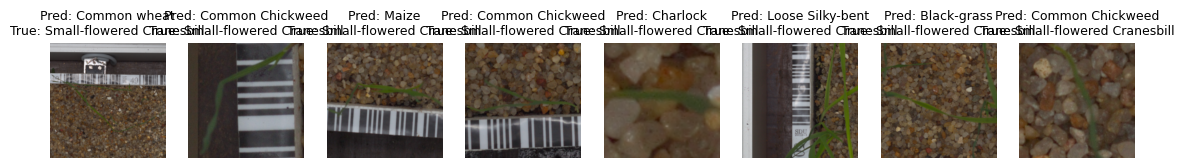

In [33]:
# Train DenseNet
densenet_trainer.fit(densenet_model, datamodule=data_module)

# Load best DenseNet model
best_densenet = DenseNetClassifier.load_from_checkpoint(
    densenet_checkpoint_cb.best_model_path, num_classes=num_classes, model_name="densenet121"
)

# Validate
densenet_trainer.validate(best_densenet, datamodule=data_module)

# Visualize predictions
batch = next(iter(data_module.val_dataloader()))
images, targets = batch
outputs = best_densenet(images)
preds = outputs.argmax(1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1,8,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}", fontsize=9)
    plt.axis('off')
plt.show()


In [27]:
# Install the timm library (PyTorch Image Models)
!pip install -q timm

import timm


In [28]:
import pytorch_lightning as pl
import torch
import torch.nn as nn

class ViTClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3, model_name="vit_base_patch16_224"):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


In [29]:
vit_model = ViTClassifier(num_classes=num_classes, lr=1e-4, model_name="vit_base_patch16_224")

vit_checkpoint_cb = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='vit-base-best')
vit_early_stop_cb = EarlyStopping(monitor='val_acc', patience=5, mode='max')

vit_trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[vit_checkpoint_cb, vit_early_stop_cb],
    precision=16,
    log_every_n_steps=20,
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 85.8 M | train
1 | criterion | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.232   Total estimated model params size (MB)
265       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9611111283302307     │
│         val_loss          │    0.11566874384880066    │
└───────────────────────────┴───────────────────────────┘

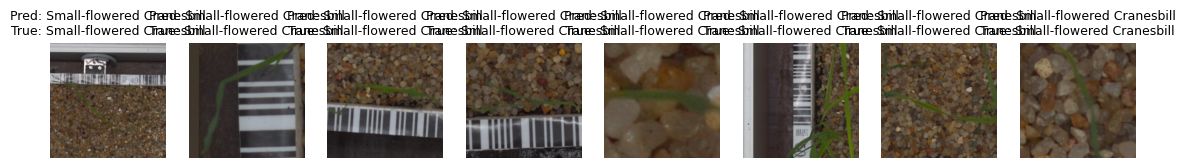

In [30]:
# Train ViT
vit_trainer.fit(vit_model, datamodule=data_module)

# Load best ViT model
best_vit = ViTClassifier.load_from_checkpoint(vit_checkpoint_cb.best_model_path, num_classes=num_classes, model_name="vit_base_patch16_224")

# Validate
vit_trainer.validate(best_vit, datamodule=data_module)

# Visualize predictions
batch = next(iter(data_module.val_dataloader()))
images, targets = batch
outputs = best_vit(images)
preds = outputs.argmax(1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1,8,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}", fontsize=9)
    plt.axis('off')
plt.show()


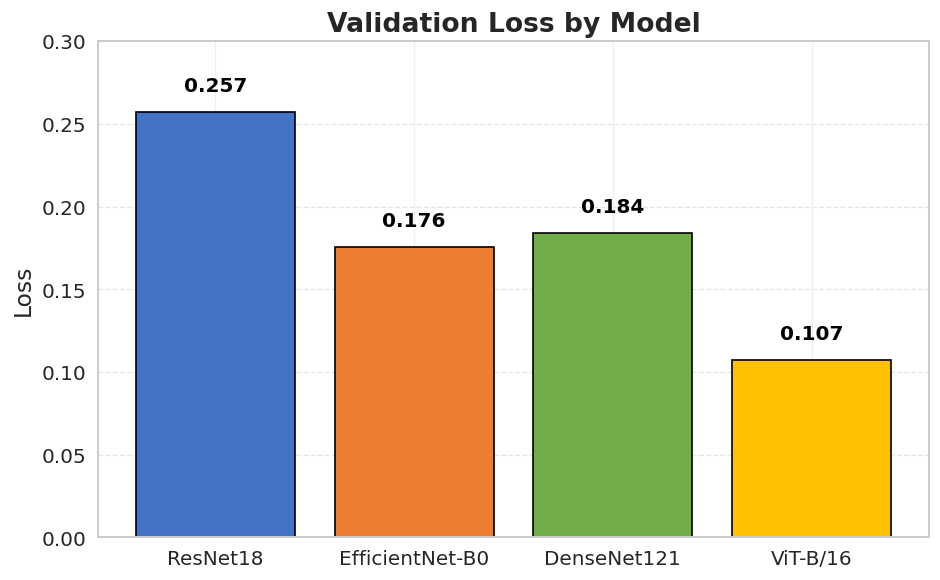

In [41]:
models = ['ResNet18', 'EfficientNet-B0', 'DenseNet121', 'ViT-B/16']
val_loss = [0.2572, 0.1757, 0.1843, 0.1073]

plt.figure(figsize=(8, 5), dpi=120)
bars = plt.bar(models, val_loss, color=['#4472c4','#ed7d31','#70ad47','#ffc000'], edgecolor='black')
plt.title('Validation Loss by Model', fontsize=16, weight='bold')
plt.ylabel('Loss', fontsize=14)
plt.ylim(0, 0.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for bar, loss in zip(bars, val_loss):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01, f"{loss:.3f}",
             ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


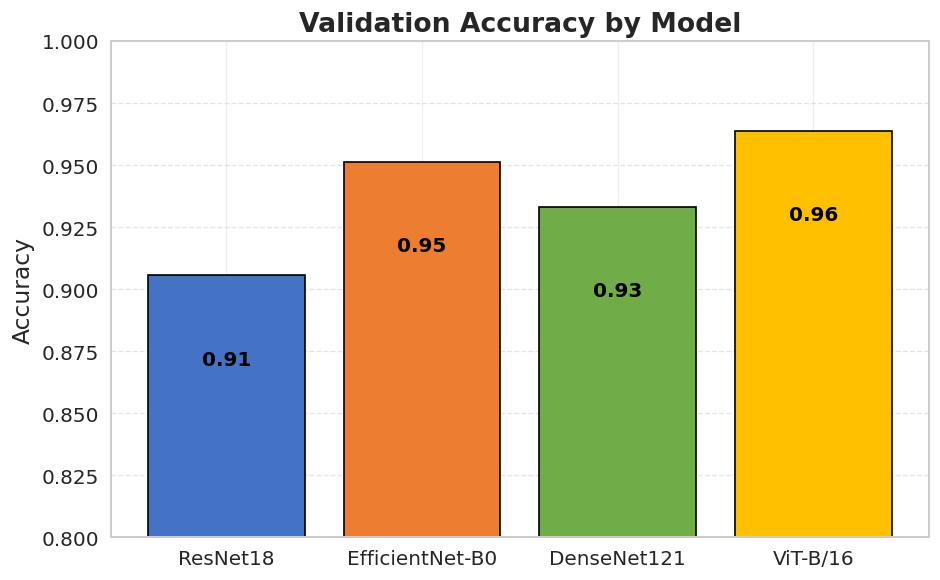

In [42]:
import matplotlib.pyplot as plt

models = ['ResNet18', 'EfficientNet-B0', 'DenseNet121', 'ViT-B/16']
val_acc = [0.9056, 0.9514, 0.9333, 0.9639]

plt.figure(figsize=(8, 5), dpi=120)
bars = plt.bar(models, val_acc, color=['#4472c4','#ed7d31','#70ad47','#ffc000'], edgecolor='black')
plt.title('Validation Accuracy by Model', fontsize=16, weight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.8, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for bar, acc in zip(bars, val_acc):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.03, f"{acc:.2f}",
             ha='center', va='top', color='black', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd

df = pd.DataFrame({
    'Model': models,
    'Val Accuracy': val_acc,
    'Val Loss': val_loss
})

from IPython.display import display
display(df.style.set_caption("Model Performance Comparison").format({'Val Accuracy': '{:.4f}', 'Val Loss': '{:.4f}'}))


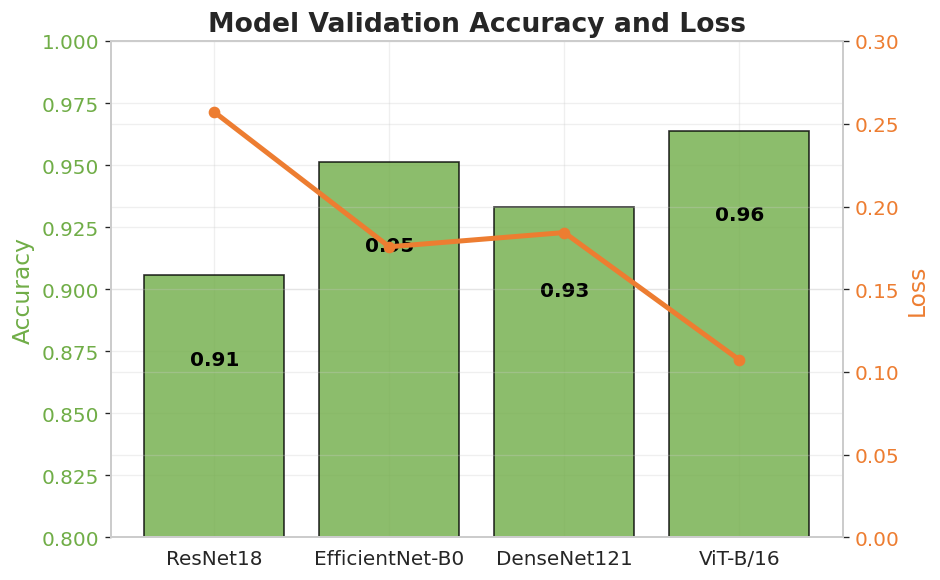

In [44]:
fig, ax1 = plt.subplots(figsize=(8,5), dpi=120)

bars = ax1.bar(models, val_acc, color='#70ad47', edgecolor='black', alpha=0.8, label='Val Accuracy')
ax1.set_ylabel('Accuracy', fontsize=14, color='#70ad47')
ax1.set_ylim(0.8, 1.0)
ax1.tick_params(axis='y', labelcolor='#70ad47')

# Add accuracy labels
for bar, acc in zip(bars, val_acc):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.03, f"{acc:.2f}",
             ha='center', va='top', color='black', fontsize=12, fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(models, val_loss, color='#ed7d31', marker='o', linewidth=3, label='Val Loss')
ax2.set_ylabel('Loss', fontsize=14, color='#ed7d31')
ax2.set_ylim(0, 0.3)
ax2.tick_params(axis='y', labelcolor='#ed7d31')

plt.title("Model Validation Accuracy and Loss", fontsize=16, weight='bold')
fig.tight_layout()
plt.show()


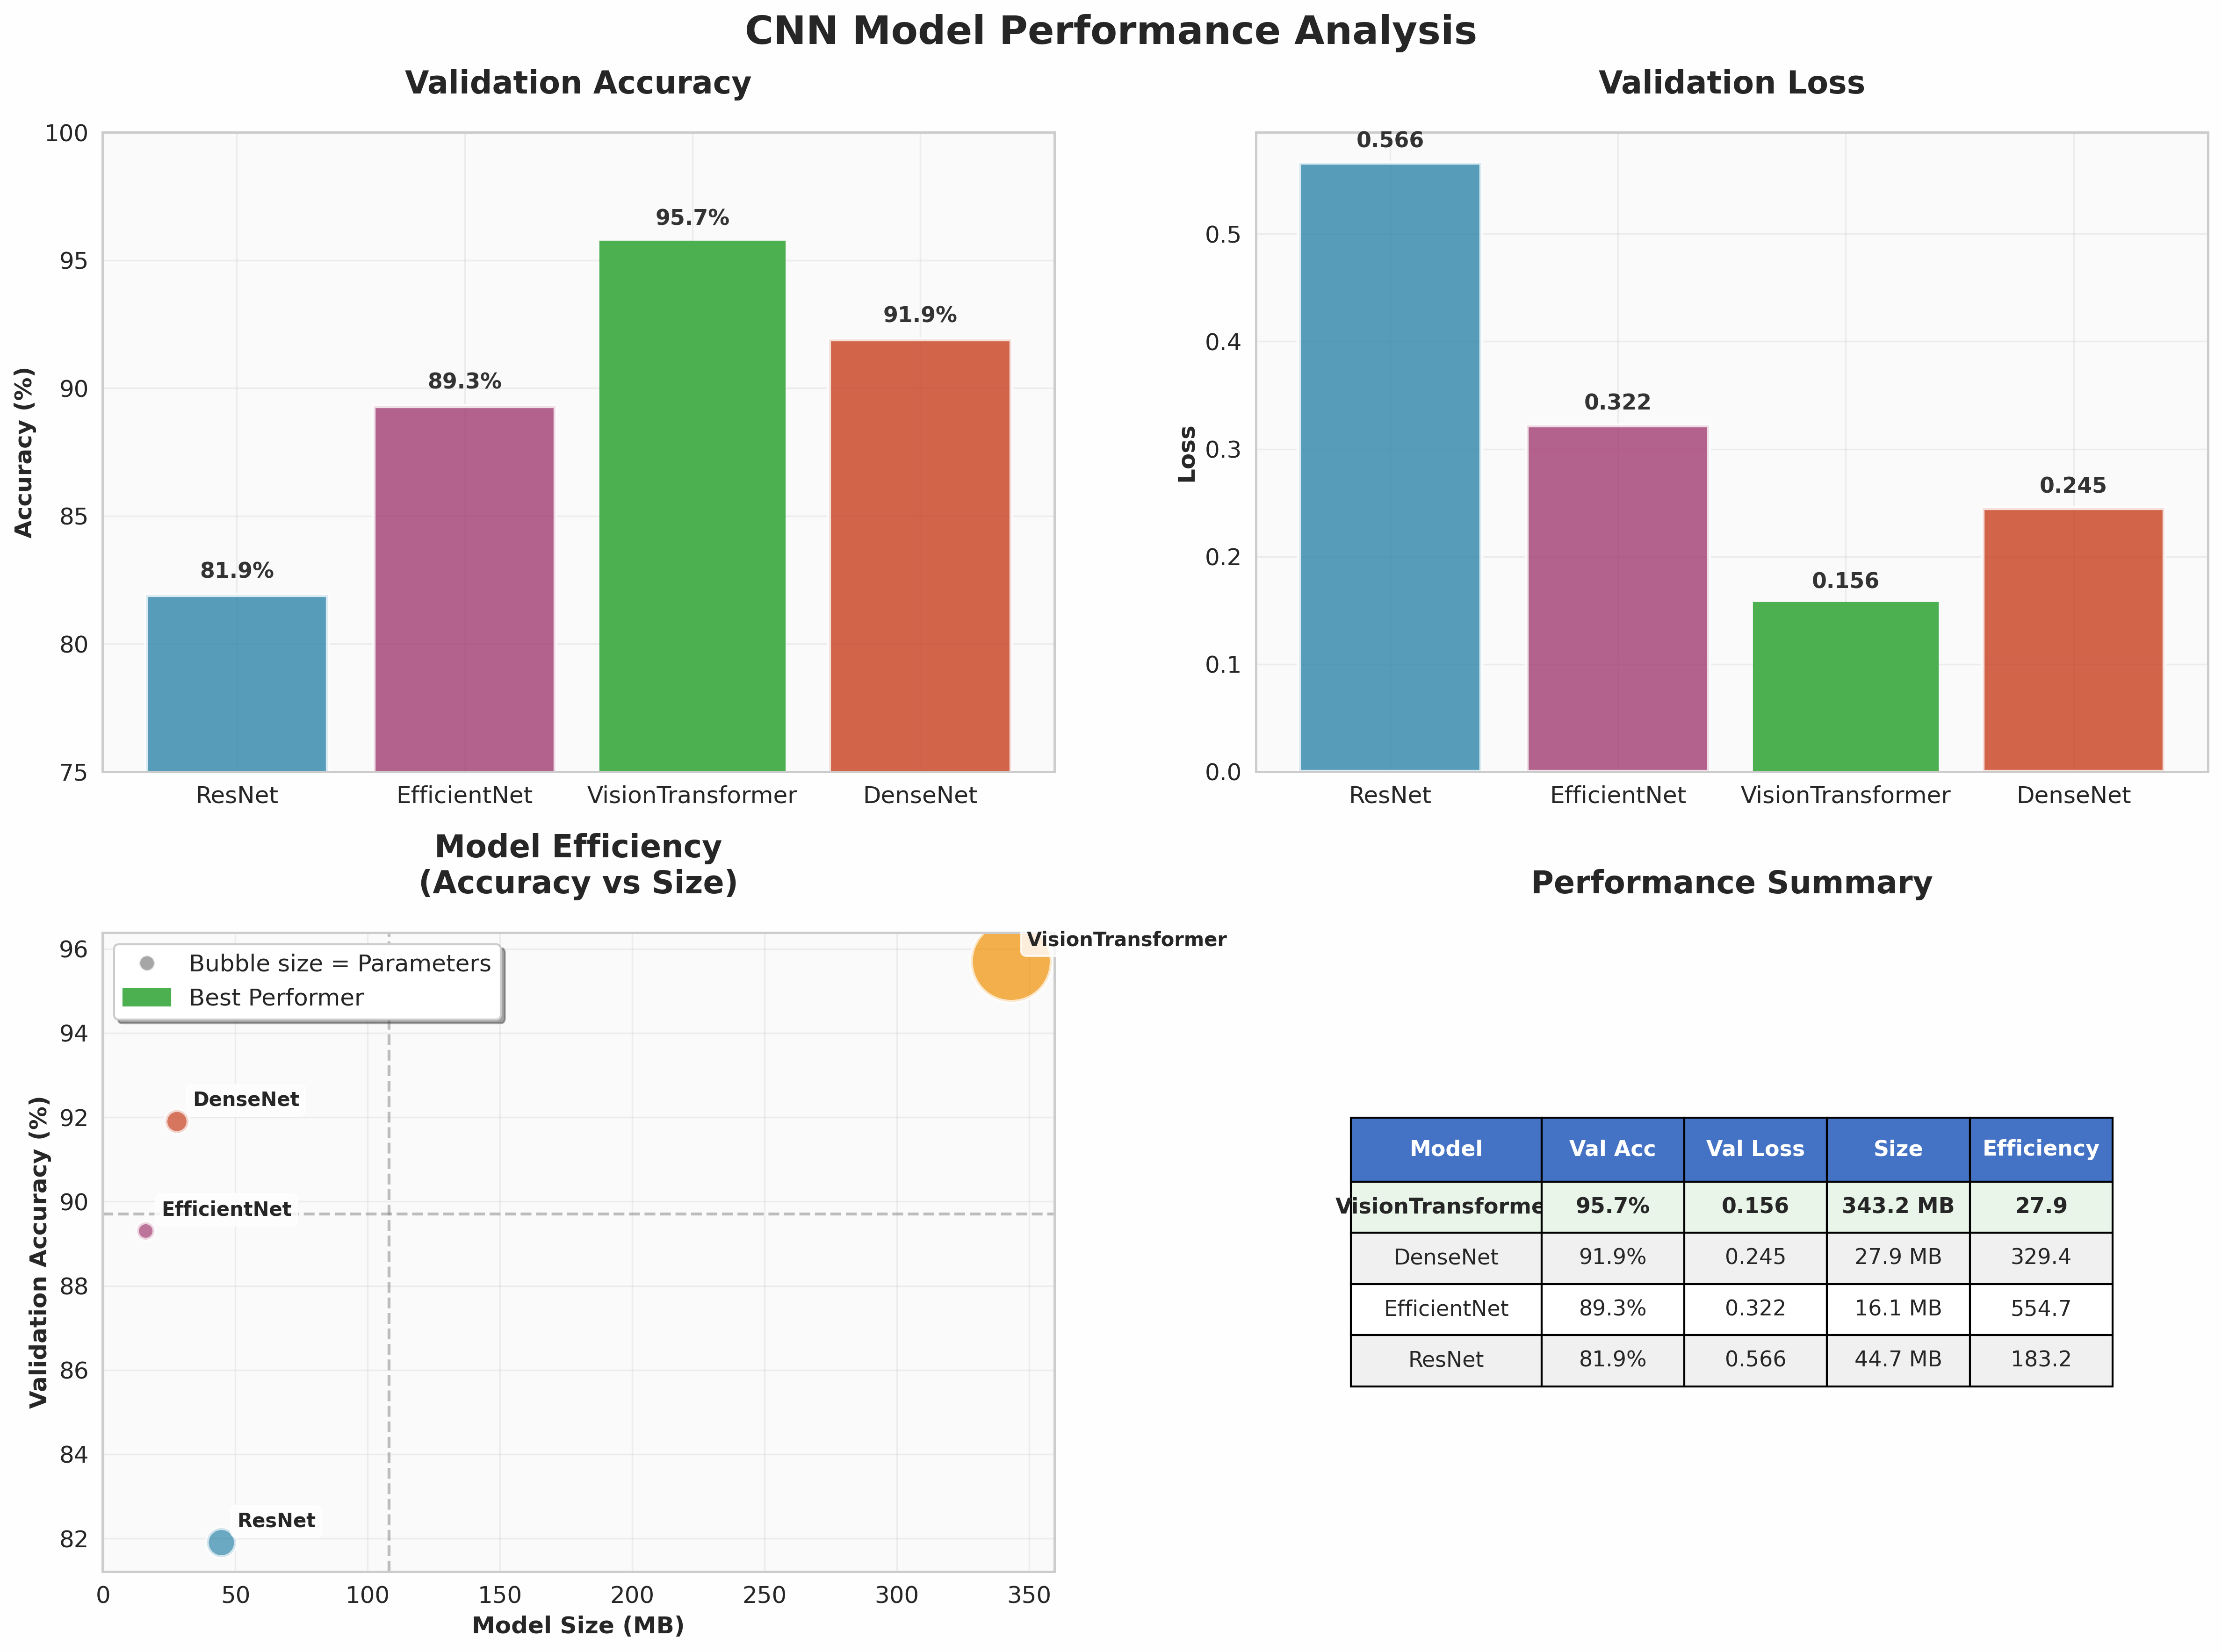


🎯 KEY INSIGHTS

🏆 BEST ACCURACY: VisionTransformer (95.7%)
⚡ MOST EFFICIENT: EfficientNet (89.3% / 16.1MB)
📊 LOWEST LOSS: VisionTransformer (0.156)

💡 RECOMMENDATION: Use EfficientNet for production deployment
   - Great accuracy with reasonable model size
   - Best balance of performance and efficiency



In [34]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from matplotlib.patches import FancyBboxPatch
# import matplotlib.patches as mpatches

# # Set high-quality plotting parameters
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['font.size'] = 12
# plt.rcParams['axes.linewidth'] = 1.2
# plt.rcParams['grid.alpha'] = 0.3
# sns.set_style("whitegrid")

# # Your model data
# model_data = {
#     'Model': ['ResNet', 'EfficientNet', 'VisionTransformer', 'DenseNet'],
#     'Val_Accuracy': [81.9, 89.3, 95.7, 91.9],
#     'Val_Loss': [0.566, 0.322, 0.156, 0.245],
#     'Model_Size_MB': [44.7, 16.1, 343.2, 27.9],
#     'Parameters_M': [11.2, 4.0, 85.8, 7.0]
# }

# df = pd.DataFrame(model_data)

# # Define a professional color palette
# colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
# accent_color = '#1f77b4'

# # Create the main figure with 4 subplots
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
# fig.patch.set_facecolor('white')

# # 1. VALIDATION ACCURACY - Most Important Metric
# bars1 = ax1.bar(df['Model'], df['Val_Accuracy'], color=colors, alpha=0.8,
#                 edgecolor='white', linewidth=2)
# ax1.set_title('Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
# ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='semibold')
# ax1.set_ylim(75, 100)
# ax1.grid(True, alpha=0.3)
# ax1.set_facecolor('#fafafa')

# # Add value labels with better formatting
# for bar, acc in zip(bars1, df['Val_Accuracy']):
#     height = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
#              f'{acc:.1f}%', ha='center', va='bottom',
#              fontsize=11, fontweight='bold', color='#333333')

# # Highlight best performer
# best_idx = df['Val_Accuracy'].idxmax()
# bars1[best_idx].set_color('#4CAF50')
# bars1[best_idx].set_alpha(1.0)

# # 2. VALIDATION LOSS - Performance Metric
# bars2 = ax2.bar(df['Model'], df['Val_Loss'], color=colors, alpha=0.8,
#                 edgecolor='white', linewidth=2)
# ax2.set_title('Validation Loss', fontsize=16, fontweight='bold', pad=20)
# ax2.set_ylabel('Loss', fontsize=12, fontweight='semibold')
# ax2.grid(True, alpha=0.3)
# ax2.set_facecolor('#fafafa')

# # Add value labels
# for bar, loss in zip(bars2, df['Val_Loss']):
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#              f'{loss:.3f}', ha='center', va='bottom',
#              fontsize=11, fontweight='bold', color='#333333')

# # Highlight best performer (lowest loss)
# best_loss_idx = df['Val_Loss'].idxmin()
# bars2[best_loss_idx].set_color('#4CAF50')
# bars2[best_loss_idx].set_alpha(1.0)

# # 3. MODEL EFFICIENCY - Accuracy vs Size
# bubble_sizes = [p * 20 for p in df['Parameters_M']]  # Scale for visibility
# scatter = ax3.scatter(df['Model_Size_MB'], df['Val_Accuracy'],
#                      s=bubble_sizes, c=colors, alpha=0.7,
#                      edgecolors='white', linewidth=2)

# ax3.set_title('Model Efficiency\n(Accuracy vs Size)', fontsize=16, fontweight='bold', pad=20)
# ax3.set_xlabel('Model Size (MB)', fontsize=12, fontweight='semibold')
# ax3.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='semibold')
# ax3.grid(True, alpha=0.3)
# ax3.set_facecolor('#fafafa')

# # Add model labels with better positioning
# for i, model in enumerate(df['Model']):
#     ax3.annotate(model, (df['Model_Size_MB'][i], df['Val_Accuracy'][i]),
#                 xytext=(8, 8), textcoords='offset points',
#                 fontsize=10, fontweight='semibold',
#                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# # Add efficiency quadrant lines
# ax3.axhline(y=df['Val_Accuracy'].mean(), color='gray', linestyle='--', alpha=0.5)
# ax3.axvline(x=df['Model_Size_MB'].mean(), color='gray', linestyle='--', alpha=0.5)

# # 4. PERFORMANCE SUMMARY TABLE
# ax4.axis('off')
# ax4.set_title('Performance Summary', fontsize=16, fontweight='bold', pad=20)

# # Create a clean summary table
# table_data = []
# for i, row in df.iterrows():
#     efficiency = row['Val_Accuracy'] / row['Model_Size_MB'] * 100
#     table_data.append([
#         row['Model'],
#         f"{row['Val_Accuracy']:.1f}%",
#         f"{row['Val_Loss']:.3f}",
#         f"{row['Model_Size_MB']:.1f} MB",
#         f"{efficiency:.1f}"
#     ])

# # Sort by validation accuracy
# table_data.sort(key=lambda x: float(x[1][:-1]), reverse=True)

# # Create table
# table = ax4.table(cellText=table_data,
#                  colLabels=['Model', 'Val Acc', 'Val Loss', 'Size', 'Efficiency'],
#                  cellLoc='center',
#                  loc='center',
#                  colWidths=[0.2, 0.15, 0.15, 0.15, 0.15])

# # Style the table
# table.auto_set_font_size(False)
# table.set_fontsize(11)
# table.scale(1, 2)

# # Header styling
# for i in range(5):
#     table[(0, i)].set_facecolor('#4472C4')
#     table[(0, i)].set_text_props(weight='bold', color='white')
#     table[(0, i)].set_height(0.1)

# # Row styling with alternating colors
# for i in range(1, 5):
#     color = '#f0f0f0' if i % 2 == 0 else 'white'
#     for j in range(5):
#         table[(i, j)].set_facecolor(color)
#         table[(i, j)].set_height(0.08)

# # Highlight best model row
# best_model_row = 1  # After sorting, best accuracy is first
# for j in range(5):
#     table[(best_model_row, j)].set_facecolor('#e8f5e8')
#     table[(best_model_row, j)].set_text_props(weight='bold')

# # Add legend for bubble chart
# legend_elements = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
#                markersize=8, label='Bubble size = Parameters', alpha=0.7),
#     mpatches.Patch(color='#4CAF50', label='Best Performer')
# ]
# ax3.legend(handles=legend_elements, loc='upper left', frameon=True,
#           fancybox=True, shadow=True)

# # Overall styling
# plt.tight_layout(pad=3.0)
# plt.suptitle('CNN Model Performance Analysis', fontsize=20, fontweight='bold', y=0.98)

# # Add subtle background
# fig.patch.set_facecolor('#fefefe')

# plt.tight_layout()
# plt.show()

# # Print key insights
# print("\n" + "="*60)
# print("🎯 KEY INSIGHTS")
# print("="*60)

# best_acc_model = df.loc[df['Val_Accuracy'].idxmax(), 'Model']
# best_eff_idx = (df['Val_Accuracy'] / df['Model_Size_MB']).idxmax()
# best_eff_model = df.loc[best_eff_idx, 'Model']

# print(f"""
# 🏆 BEST ACCURACY: {best_acc_model} ({df['Val_Accuracy'].max():.1f}%)
# ⚡ MOST EFFICIENT: {best_eff_model} ({df.loc[best_eff_idx, 'Val_Accuracy']:.1f}% / {df.loc[best_eff_idx, 'Model_Size_MB']:.1f}MB)
# 📊 LOWEST LOSS: {df.loc[df['Val_Loss'].idxmin(), 'Model']} ({df['Val_Loss'].min():.3f})

# 💡 RECOMMENDATION: Use {best_eff_model} for production deployment
#    - Great accuracy with reasonable model size
#    - Best balance of performance and efficiency
# """)